# [ml4ir](https://github.com/salesforce/ml4ir) 
#### open source, modular, python3 library for IR based ML applications
--------------------

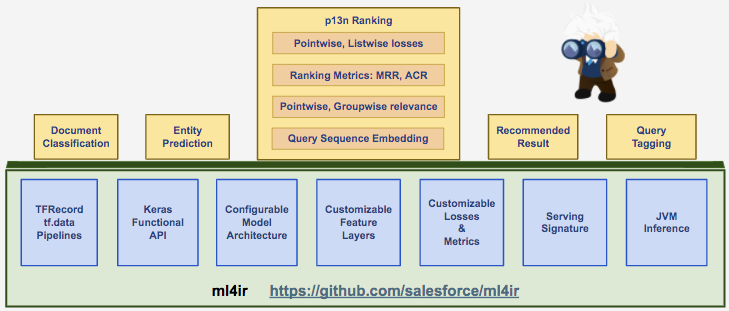

### First, let's load the data and take a look at it

In [28]:
from ml4ir.io import file_io
import glob
import logging

# Setup logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("Logger is initialized...")


# Load data
df = file_io.read_df_list(glob.glob('/Users/ashish.srinivasa/search_relevance/ml4ir/python/applications/ranking/tests/data/csv/train/*.csv'), log=logger)

logger.info(df.shape)

df.head().T

DEBUG:root:Logger is initialized...
INFO:root:Reading 1 files from [/Users/ashish.srinivasa/search_relevance/ml4ir/python/applications/ranking/tests/data/csv/train/file_0.csv, ..
INFO:root:(5676, 8)


,0,1,2,3,4
query_key,2,2,5,5,5
query_str,MHS7A7RJB1Y4BJT,MHS7A7RJB1Y4BJT,KNJNWV,KNJNWV,KNJNWV
pos,2,1,6,3,4
feat_0,0.47373,1.06319,1.36811,1.37063,1.3667
feat_1,0,0.205381,0.030636,0.0412615,0.0825349
feat_2,0,0.30103,0,0.30103,0.30103
label,0,1,0,0,0
group,2,2,0,0,0


### Let's define the feature configuration for our data

### ... brace yourselves!

In [12]:
# Set up the feature configurations
from ml4ir.features.feature_config import parse_config
from ml4ir.features.feature_config import ExampleFeatureConfig
from ml4ir.config.keys import TFRecordTypeKey
import json

feature_config_yaml = '''
query_key: 
  name: query_key
  node_name: query_key
  trainable: false
  dtype: int64
  log_at_inference: true
  feature_layer_info:
    type: numeric
    shape: null
  serving_info:
    required: false
    default_value: 0
  tfrecord_type: context
label:
  name: label
  node_name: label
  trainable: false
  dtype: int64
  log_at_inference: true
  feature_layer_info:
    type: numeric
    shape: null
  serving_info:
    required: false
    default_value: 0
  tfrecord_type: sequence
features:
  - name: feat_0
    node_name: feat_0
    trainable: true
    dtype: float
    log_at_inference: false
    feature_layer_info:
      type: numeric
      shape: null
    serving_info:
      required: true
      default_value: 0.0
    tfrecord_type: sequence
  - name: feat_1
    node_name: feat_1
    trainable: true
    dtype: float
    log_at_inference: false
    feature_layer_info:
      type: numeric
      shape: null
    serving_info:
      required: true
      default_value: 0.0
    tfrecord_type: sequence
  - name: feat_2
    node_name: feat_2
    trainable: true
    dtype: float
    log_at_inference: false
    feature_layer_info:
      type: numeric
      shape: null
    serving_info:
      required: true
      default_value: 0.0
    tfrecord_type: sequence
  - name: query_str
    node_name: query_str
    trainable: true
    dtype: string
    log_at_inference: true
    feature_layer_info:
      type: numeric
      shape: null
      fn: get_sequence_encoding
      args:
        encoding_type: bilstm
        encoding_size: 128
        embedding_size: 128
        max_length: 20
    preprocessing_info:
      - fn: preprocess_text
        args:
          remove_punctuation: true
          to_lower: true
      - fn: strip_numbers
    serving_info:
      required: true
      default_value: ""
    tfrecord_type: context
  - name: group
    node_name: group
    trainable: true
    dtype: int64
    log_at_inference: false
    is_group_metric_key: true
    feature_layer_info:
      type: numeric
      shape: null
      fn: custom_categorical_embedding
      args:
        vocabulary_size: 16
        embedding_size: 128
    serving_info:
      required: false
      default_value: 0
    tfrecord_type: context
  - name: pos
    node_name: pos
    trainable: false
    dtype: int64
    log_at_inference: true
    feature_layer_info:
      type: numeric
      shape: null
    serving_info:
      required: true
      default_value: 0
    tfrecord_type: sequence
'''
feature_config: ExampleFeatureConfig = parse_config(TFRecordTypeKey.EXAMPLE, feature_config_yaml, logger=logger)
    
logging.info(json.dumps(feature_config.get_all_features(), indent=4))

DEBUG:root:Logger is initialized...
INFO:root:Reading feature config from YAML string
INFO:root:Feature config loaded successfully
INFO:root:Trainable Features : 
feat_0
feat_1
feat_2
query_str
group
INFO:root:Label : label
INFO:root:Metadata Features : 
query_key
label
pos
INFO:root:[
    {
        "name": "query_key",
        "node_name": "query_key",
        "trainable": false,
        "dtype": "int64",
        "log_at_inference": true,
        "feature_layer_info": {
            "type": "numeric",
            "shape": null
        },
        "serving_info": {
            "required": false,
            "default_value": 0
        },
        "tfrecord_type": "context"
    },
    {
        "name": "label",
        "node_name": "label",
        "trainable": false,
        "dtype": "int64",
        "log_at_inference": true,
        "feature_layer_info": {
            "type": "numeric",
            "shape": null
        },
        "serving_info": {
            "required": false,
         

## TFRecords - Examples vs SequenceExamples

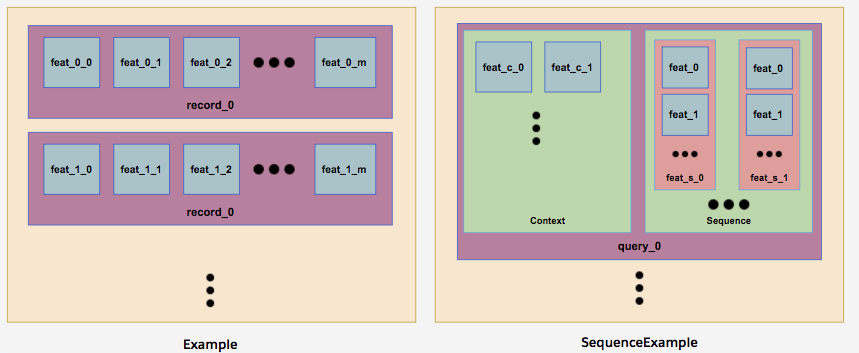

### Time to load the data and save awesome TFRecords

In [13]:
from ml4ir.io import file_io
from ml4ir.data import tfrecord_writer
import glob

# Load data
df = file_io.read_df_list(glob.glob('/Users/ashish.srinivasa/search_relevance/ml4ir/python/applications/ranking/tests/data/csv/train/file_0.csv'))

# Save as TFRecord SequenceExample/Example
tfrecord_writer.write_from_df(df,
                              tfrecord_file='/Users/ashish.srinivasa/search_relevance/data/demo/tfrecords/file_0.tfrecord',
                              feature_config=feature_config,
                              tfrecord_type=TFRecordTypeKey.EXAMPLE)

# Let's see what it looks like
df.head()

,query_key,query_str,pos,feat_0,feat_1,feat_2,label,group
0,2,MHS7A7RJB1Y4BJT,2,0.473730,0.000000,0.00000,0,2
1,2,MHS7A7RJB1Y4BJT,1,1.063190,0.205381,0.30103,1,2
2,5,KNJNWV,6,1.368108,0.030636,0.00000,0,0
3,5,KNJNWV,3,1.370628,0.041261,0.30103,0,0
4,5,KNJNWV,4,1.366700,0.082535,0.30103,0,0


### Load TFRecords and add custom preprocessing functions

In [14]:
from ml4ir.data import tfrecord_reader
from tensorflow import print as tfprint
import tensorflow as tf

@tf.function
def strip_numbers(feature_tensor):
    return tf.strings.regex_replace(feature_tensor, "[0-9]", "")

# Define per instance preprocessing functions
preprocessing_fns = {
    "strip_numbers": strip_numbers
}

# Create a TFRecord dataset
dataset = tfrecord_reader.read(data_dir='/Users/ashish.srinivasa/search_relevance/data/demo/tfrecords/',
                               feature_config=feature_config,
                               tfrecord_type=TFRecordTypeKey.EXAMPLE,
                               preprocessing_keys_to_fns=preprocessing_fns)

tfprint(next(iter(dataset.batch(5))))

{'query_key': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'label': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'feat_0': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_1': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_2': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'query_str': FixedLenFeature(shape=[], dtype='string', default_value=''), 'group': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'pos': FixedLenFeature(shape=[], dtype='int64', default_value=0)}
({'feat_0': [[0.473729521]
 [1.06319]
 [1.36810815]
 [1.37062836]
 [1.36669993]],
  'feat_1': [[0]
 [0.205380633]
 [0.0306360275]
 [0.0412614979]
 [0.0825348869]],
  'feat_2': [[0]
 [0.30103]
 [0]
 [0.30103]
 [0.30103]],
  'group': [[2]
 [2]
 [0]
 [0]
 [0]],
  'pos': [[2]
 [1]
 [6]
 [3]
 [4]],
  'query_key': [[2]
 [2]
 [5]
 [5]
 [5]],
  'query_str': [["mhsarjbybjt"]
 ["mhsarjbybjt"]
 ["knjnwv"]
 ["knjnwv"]
 ["knjnwv"]]},
 [[0]
 [1]
 [

### Map, Filter, Filter, Batch the Dataset

In [15]:
# Variety of map, reduce, filter, shuffle operations can be used here
# dataset = dataset.<map, filter, reduce>(tf_preprocess_fn)

# NOTE: This is lazy batching
dataset = dataset.batch(batch_size=128, drop_remainder=True)

### Or... you can do all of that for train, val and test in _one_ step!

In [16]:
from ml4ir.data.relevance_dataset import RelevanceDataset
from ml4ir.config.keys import DataFormatKey

relevance_dataset = RelevanceDataset(
        data_dir='/Users/ashish.srinivasa/search_relevance/ml4ir/python/applications/ranking/tests/data/csv',
        data_format=DataFormatKey.CSV,
        feature_config=feature_config,
        tfrecord_type=TFRecordTypeKey.EXAMPLE,
        batch_size=128,
        preprocessing_keys_to_fns=preprocessing_fns,
        logger=logger
    )

tfprint(relevance_dataset.train)
tfprint(relevance_dataset.validation)
tfprint(relevance_dataset.test)

INFO:root:Reading 1 files from [/Users/ashish.srinivasa/search_relevance/ml4ir/python/applications/ranking/tests/data/csv/train/file_0.csv, ..
INFO:root:Writing SequenceExample protobufs to : /Users/ashish.srinivasa/search_relevance/ml4ir/python/applications/ranking/tests/data/csv/tfrecord/train/file_0.tfrecord
INFO:root:Created TFRecordDataset from SequenceExample protobufs from 1 files : ['/Users/ashish.srinivasa/search_relevance/ml4ir/p
INFO:root:Reading 1 files from [/Users/ashish.srinivasa/search_relevance/ml4ir/python/applications/ranking/tests/data/csv/validation/file_0.csv, ..
INFO:root:Writing SequenceExample protobufs to : /Users/ashish.srinivasa/search_relevance/ml4ir/python/applications/ranking/tests/data/csv/tfrecord/validation/file_0.tfrecord


{'query_key': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'label': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'feat_0': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_1': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_2': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'query_str': FixedLenFeature(shape=[], dtype='string', default_value=''), 'group': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'pos': FixedLenFeature(shape=[], dtype='int64', default_value=0)}


INFO:root:Created TFRecordDataset from SequenceExample protobufs from 1 files : ['/Users/ashish.srinivasa/search_relevance/ml4ir/p
INFO:root:Reading 1 files from [/Users/ashish.srinivasa/search_relevance/ml4ir/python/applications/ranking/tests/data/csv/test/file_0.csv, ..
INFO:root:Writing SequenceExample protobufs to : /Users/ashish.srinivasa/search_relevance/ml4ir/python/applications/ranking/tests/data/csv/tfrecord/test/file_0.tfrecord


{'query_key': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'label': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'feat_0': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_1': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_2': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'query_str': FixedLenFeature(shape=[], dtype='string', default_value=''), 'group': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'pos': FixedLenFeature(shape=[], dtype='int64', default_value=0)}


INFO:root:Created TFRecordDataset from SequenceExample protobufs from 1 files : ['/Users/ashish.srinivasa/search_relevance/ml4ir/p


{'query_key': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'label': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'feat_0': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_1': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_2': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'query_str': FixedLenFeature(shape=[], dtype='string', default_value=''), 'group': FixedLenFeature(shape=[], dtype='int64', default_value=0), 'pos': FixedLenFeature(shape=[], dtype='int64', default_value=0)}
<BatchDataset shapes: ({query_key: (128, 1), feat_0: (128, 1), feat_1: (128, 1), feat_2: (128, 1), query_str: (128, 1), group: (128, 1), pos: (128, 1)}, (128, 1)), types: ({query_key: tf.int64, feat_0: tf.float32, feat_1: tf.float32, feat_2: tf.float32, query_str: tf.string, group: tf.int64, pos: tf.int64}, tf.int64)>
<BatchDataset shapes: ({query_key: (128, 1), feat_0: (128, 1), feat_1: (128, 1), feat_2: (128, 1), query_str: (128, 1)

## Let's define a model, already!

### Model Framework

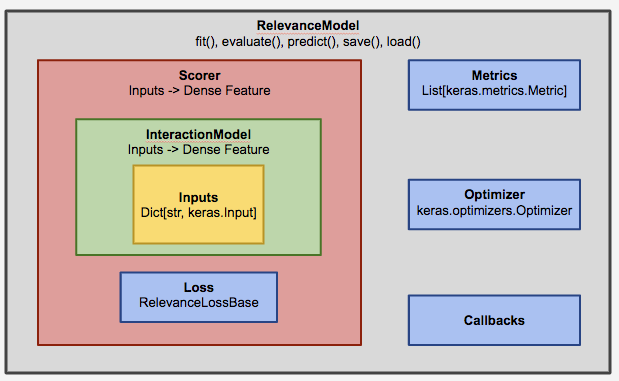

### Step 0: Define the Interaction Model

In [18]:
from ml4ir.model.scoring.interaction_model import InteractionModel, UnivariateInteractionModel
from ml4ir.config.keys import TFRecordTypeKey

# Define custom feature layer ops
def get_categorical_embedding(input_feature, feature_info):
    """Embedding lookup for categorical features"""
    
    feature_layer_info = feature_info.get("feature_layer_info")
    return layers.Embedding(input_dim=feature_layer_info["args"]["vocabulary_size"],
                     output_dim=feature_layer_info["args"]["embedding_size"],
                     name="categorical_embedding_{}".format(feature_info.get("name")),
                 )(input_feature)

feature_layer_fns = {
    "custom_categorical_embedding": get_categorical_embedding
}

interaction_model: InteractionModel = UnivariateInteractionModel(
                                            feature_config=feature_config,
                                            feature_layer_keys_to_fns=feature_layer_fns,
                                            tfrecord_type=TFRecordTypeKey.EXAMPLE)

### Step 1: Define the Scorer

In [19]:
from ml4ir.model.scoring.scoring_model import ScorerBase, RelevanceScorer
from ml4ir.model.losses.loss_base import RelevanceLossBase
from tensorflow.keras import layers
from tensorflow.keras import losses

class MyCustomLoss(RelevanceLossBase):
    def get_loss_fn(self, **kwargs):
        """
        Define a sigmoid cross entropy loss
        Additionally can pass in record positions to handle positional bias

        """
        bce = losses.BinaryCrossentropy(reduction=losses.Reduction.SUM_OVER_BATCH_SIZE)
        mask = kwargs.get("mask")

        def _loss_fn(y_true, y_pred):
            # NOTE: Can use any of the metadata features to qualify your loss here
            return bce(y_true, y_pred)

        return _loss_fn

    def get_final_activation_op(self, output_name):
        return lambda logits, mask: layers.Activation("sigmoid", name=output_name)(logits)

scorer: ScorerBase = RelevanceScorer.from_model_config_file(
    model_config_file='/Users/ashish.srinivasa/search_relevance/ml4ir/python/ml4ir/config/default_model_config.yaml',
    interaction_model=interaction_model,
    loss=MyCustomLoss(),
    output_name="relevance_score")
    
logger.info(json.dumps(scorer.model_config, indent=4))

INFO:root:{
    "architecture_key": "dnn",
    "layers": [
        {
            "type": "dense",
            "name": "first_dense",
            "units": 256,
            "activation": "relu"
        },
        {
            "type": "dropout",
            "name": "first_dropout",
            "rate": 0.0
        },
        {
            "type": "dense",
            "name": "second_dense",
            "units": 64,
            "activation": "relu"
        },
        {
            "type": "dropout",
            "name": "second_dropout",
            "rate": 0.0
        },
        {
            "type": "dense",
            "name": "final_dense",
            "units": 1,
            "activation": null
        }
    ]
}


### Step 2: Define Metrics

In [20]:
from tensorflow.keras import metrics as kmetrics

metrics = ['binary_accuracy', kmetrics.Precision(name='precision')]

### Step 3: Define Optimizer

In [21]:
from tensorflow.keras.optimizers import Optimizer
from ml4ir.model.optimizer import get_optimizer
from ml4ir.config.keys import OptimizerKey

optimizer: Optimizer = get_optimizer(
                optimizer_key=OptimizerKey.ADAM,
                learning_rate=0.01,
                learning_rate_decay=0.94,
                learning_rate_decay_steps=1000,
                gradient_clip_value=50,
            )

### Now... let's put it all together (shhh!)

In [22]:
from ml4ir.model.relevance_model import RelevanceModel
from ml4ir.config.keys import OptimizerKey

relevance_model = RelevanceModel(
        feature_config=feature_config,
        scorer=scorer,
        metrics=metrics,
        optimizer=optimizer,
        tfrecord_type=TFRecordTypeKey.EXAMPLE,
        output_name="relevance_score",
        logger=logger
    )

INFO:root:Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
query_str (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_DecodePaddedRaw_1 ( [(None, 1, 20)]      0           query_str[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Reshape_1 (TensorFl [(None, 20)]         0           tf_op_layer_DecodePaddedRaw_1[0][
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 128)      32768       tf_op_layer_Reshape_1[0][0]      
__________________________________________________________________________________

In [23]:
relevance_model.fit(relevance_dataset, 
                    num_epochs=5, 
                    models_dir='/Users/ashish.srinivasa/search_relevance/model_training/test/models',
                    logs_dir='/Users/ashish.srinivasa/search_relevance/model_training/test/logs',
                    monitor_metric='val_binary_accuracy',
                    monitor_mode='max')

INFO:root:Training Model
INFO:root:Starting Epoch : 1
INFO:root:{}


Epoch 1/5


INFO:root:[epoch: 1 | batch: 0] {'batch': 0, 'size': 128, 'loss': 0.71008205, 'binary_accuracy': 0.25, 'precision': 0.25}


      1/Unknown - 9s 9s/step - loss: 0.7101 - binary_accuracy: 0.2500 - precision: 0.2500WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.171966). Check your callbacks.


     25/Unknown - 11s 441ms/step - loss: 0.5770 - binary_accuracy: 0.7169 - precision: 0.2558

INFO:root:[epoch: 1 | batch: 25] {'batch': 25, 'size': 128, 'loss': 0.5621136, 'binary_accuracy': 0.7175481, 'precision': 0.25581396}


     44/Unknown - 12s 277ms/step - loss: 0.5694 - binary_accuracy: 0.7227 - precision: 0.2907

INFO:root:Evaluating Model
INFO:root:Completed evaluating model
INFO:root:None



Epoch 00001: val_binary_accuracy improved from -inf to 0.73899, saving model to /Users/ashish.srinivasa/search_relevance/model_training/test/models/checkpoint.tf
INFO:tensorflow:Assets written to: /Users/ashish.srinivasa/search_relevance/model_training/test/models/checkpoint.tf/assets


INFO:tensorflow:Assets written to: /Users/ashish.srinivasa/search_relevance/model_training/test/models/checkpoint.tf/assets
INFO:root:End of Epoch 1
INFO:root:{'loss': 0.5694439898837697, 'binary_accuracy': 0.72265625, 'precision': 0.29069766, 'val_loss': 0.5495109124617144, 'val_binary_accuracy': 0.7389915, 'val_precision': 0.0}


44/44 [==============================] - 41s 930ms/step - loss: 0.5694 - binary_accuracy: 0.7227 - precision: 0.2907 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_precision: 0.0000e+00


INFO:root:Starting Epoch : 2
INFO:root:{}
INFO:root:[epoch: 2 | batch: 0] {'batch': 0, 'size': 128, 'loss': 0.5451975, 'binary_accuracy': 0.75, 'precision': 0.0}


Epoch 2/5
25/44 [================>.............] - ETA: 1s - loss: 0.5516 - binary_accuracy: 0.7366 - precision: 0.5000   

INFO:root:[epoch: 2 | batch: 25] {'batch': 25, 'size': 128, 'loss': 0.56510526, 'binary_accuracy': 0.7364784, 'precision': 0.5}


43/44 [============================>.] - ETA: 0s - loss: 0.5522 - binary_accuracy: 0.7335 - precision: 0.4342

INFO:root:Evaluating Model
INFO:root:Completed evaluating model
INFO:root:None
INFO:root:End of Epoch 2
INFO:root:{'loss': 0.5526189621199261, 'binary_accuracy': 0.7334872, 'precision': 0.42857143, 'val_loss': 0.5516237860376184, 'val_binary_accuracy': 0.73828125, 'val_precision': 0.16666667}



Epoch 00002: val_binary_accuracy did not improve from 0.73899
44/44 [==============================] - 4s 98ms/step - loss: 0.5526 - binary_accuracy: 0.7335 - precision: 0.4286 - val_loss: 0.5516 - val_binary_accuracy: 0.7383 - val_precision: 0.1667


INFO:root:Starting Epoch : 3
INFO:root:{}
INFO:root:[epoch: 3 | batch: 0] {'batch': 0, 'size': 128, 'loss': 0.5478337, 'binary_accuracy': 0.75, 'precision': 0.0}


Epoch 3/5
25/44 [================>.............] - ETA: 1s - loss: 0.5491 - binary_accuracy: 0.7350 - precision: 0.3529   

INFO:root:[epoch: 3 | batch: 25] {'batch': 25, 'size': 128, 'loss': 0.5682589, 'binary_accuracy': 0.734375, 'precision': 0.31578946}


43/44 [============================>.] - ETA: 0s - loss: 0.5496 - binary_accuracy: 0.7335 - precision: 0.4038

INFO:root:Evaluating Model
INFO:root:Completed evaluating model
INFO:root:None



Epoch 00003: val_binary_accuracy improved from 0.73899 to 0.73917, saving model to /Users/ashish.srinivasa/search_relevance/model_training/test/models/checkpoint.tf
INFO:tensorflow:Assets written to: /Users/ashish.srinivasa/search_relevance/model_training/test/models/checkpoint.tf/assets


INFO:tensorflow:Assets written to: /Users/ashish.srinivasa/search_relevance/model_training/test/models/checkpoint.tf/assets
INFO:root:End of Epoch 3
INFO:root:{'loss': 0.5501408048651435, 'binary_accuracy': 0.73366475, 'precision': 0.40384614, 'val_loss': 0.5551874244754965, 'val_binary_accuracy': 0.73916906, 'val_precision': 1.0}


44/44 [==============================] - 35s 786ms/step - loss: 0.5501 - binary_accuracy: 0.7337 - precision: 0.4038 - val_loss: 0.5552 - val_binary_accuracy: 0.7392 - val_precision: 1.0000


INFO:root:Starting Epoch : 4
INFO:root:{}
INFO:root:[epoch: 4 | batch: 0] {'batch': 0, 'size': 128, 'loss': 0.54587984, 'binary_accuracy': 0.75, 'precision': 0.0}


Epoch 4/5
25/44 [================>.............] - ETA: 1s - loss: 0.5489 - binary_accuracy: 0.7366 - precision: 0.0000e+00

INFO:root:[epoch: 4 | batch: 25] {'batch': 25, 'size': 128, 'loss': 0.5577152, 'binary_accuracy': 0.7364784, 'precision': 0.0}


43/44 [============================>.] - ETA: 0s - loss: 0.5486 - binary_accuracy: 0.7351 - precision: 0.4444

INFO:root:Evaluating Model
INFO:root:Completed evaluating model
INFO:root:None
INFO:root:End of Epoch 4
INFO:root:{'loss': 0.5492826747623357, 'binary_accuracy': 0.7352628, 'precision': 0.44444445, 'val_loss': 0.5600811798464168, 'val_binary_accuracy': 0.73881394, 'val_precision': 0.33333334}



Epoch 00004: val_binary_accuracy did not improve from 0.73917
44/44 [==============================] - 4s 98ms/step - loss: 0.5493 - binary_accuracy: 0.7353 - precision: 0.4444 - val_loss: 0.5601 - val_binary_accuracy: 0.7388 - val_precision: 0.3333


INFO:root:Starting Epoch : 5
INFO:root:{}
INFO:root:[epoch: 5 | batch: 0] {'batch': 0, 'size': 128, 'loss': 0.5590575, 'binary_accuracy': 0.75, 'precision': 0.0}


Epoch 5/5
25/44 [================>.............] - ETA: 1s - loss: 0.5496 - binary_accuracy: 0.7366 - precision: 0.0000e+00

INFO:root:[epoch: 5 | batch: 25] {'batch': 25, 'size': 128, 'loss': 0.56295305, 'binary_accuracy': 0.7364784, 'precision': 0.0}


43/44 [============================>.] - ETA: 0s - loss: 0.5481 - binary_accuracy: 0.7347 - precision: 0.2000

INFO:root:Evaluating Model
INFO:root:Completed evaluating model
INFO:root:None
INFO:root:End of Epoch 5
INFO:root:{'loss': 0.548423870043321, 'binary_accuracy': 0.7349077, 'precision': 0.2, 'val_loss': 0.5594554760239341, 'val_binary_accuracy': 0.7389915, 'val_precision': 0.0}



Epoch 00005: val_binary_accuracy did not improve from 0.73917
Restoring model weights from the end of the best epoch.
44/44 [==============================] - 5s 109ms/step - loss: 0.5484 - binary_accuracy: 0.7349 - precision: 0.2000 - val_loss: 0.5595 - val_binary_accuracy: 0.7390 - val_precision: 0.0000e+00


INFO:root:Completed training model
INFO:root:None


Epoch 00005: early stopping


### Let's save the model(... and don't forget about serving signatures)

In [24]:
relevance_model.save(
    models_dir='/Users/ashish.srinivasa/search_relevance/model_training/test/models',
    preprocessing_keys_to_fns=preprocessing_fns,
    required_fields_only=True)

INFO:tensorflow:Assets written to: /Users/ashish.srinivasa/search_relevance/model_training/test/models/final/default/assets


INFO:tensorflow:Assets written to: /Users/ashish.srinivasa/search_relevance/model_training/test/models/final/default/assets


{'feat_0': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_1': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'feat_2': FixedLenFeature(shape=[], dtype='float', default_value=0.0), 'query_str': FixedLenFeature(shape=[], dtype='string', default_value=''), 'pos': FixedLenFeature(shape=[], dtype='int64', default_value=0)}
INFO:tensorflow:Assets written to: /Users/ashish.srinivasa/search_relevance/model_training/test/models/final/tfrecord/assets


INFO:tensorflow:Assets written to: /Users/ashish.srinivasa/search_relevance/model_training/test/models/final/tfrecord/assets
INFO:root:Final model saved to : /Users/ashish.srinivasa/search_relevance/model_training/test/models/final


### Reload the model for some fun

### Make some predictions